In [20]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd

country_map = {
    'BDI': 'Burundi', 'COD': 'Democratic Republic of the Congo', 'ETH': 'Ethiopia',
    'MUS': 'Mauritius', 'GNQ': 'Equatorial Guinea', 'SYC': 'Seychelles',
    'NPL': 'Nepal', 'BGD': 'Bangladesh', 'IND': 'India',
    'BTN': 'Bhutan', 'LKA': 'Sri Lanka', 'MDV': 'Maldives'
}
features = ['gdp_per_capita_constant_usd', 'primary_school_enrollment', 
            'basic_water_access_pct', 'basic_sanitation_access_pct']
col_rename = {'gdp_per_capita_constant_usd': 'GDP', 'primary_school_enrollment': 'School_Enroll',
              'basic_water_access_pct': 'Water_Access', 'basic_sanitation_access_pct': 'Sanitation'}

data = pd.read_csv('data/qtm350_final.csv').dropna(subset=features + ['life_expectancy_birth'])

In [ ]:
def get_importance(df):
    if len(df) < 5: return None
    rf = RandomForestRegressor(n_estimators=100, random_state=1234)
    rf.fit(df[features], df['life_expectancy_birth'])
    return pd.Series(rf.feature_importances_ * 100, index=features)

tables = {'Regions': [], 'Sub-Saharan Africa': [], 'South Asia': []}

for region in ['Sub-Saharan Africa', 'South Asia']:
    # A. Regional Analysis
    reg_df = data[data['Region'] == region]
    imp = get_importance(reg_df)
    imp.name = region
    tables['Regions'].append(imp)
    
    # B. Country Selection
    valid_counts = reg_df['Country'].value_counts()
    valid_countries = valid_counts[valid_counts >= 5].index
    reg_valid = reg_df[reg_df['Country'].isin(valid_countries)]
    
    # Rank by GDP (3 Lowest + 3 Highest)
    gdp_rank = reg_valid.groupby('Country')['gdp_per_capita_constant_usd'].mean().sort_values()
    selection = gdp_rank.index[:3].tolist() + gdp_rank.index[-3:].tolist()
    
    # C. Country Analysis
    for code in selection:
        c_imp = get_importance(reg_valid[reg_valid['Country'] == code])
        if c_imp is not None:
            c_imp.name = country_map.get(code, code)
            tables[region].append(c_imp)

In [18]:
for name, data_list in tables.items():
    print(f"\nTable: {name}")
    display(pd.DataFrame(data_list).rename(columns=col_rename).map(lambda x: f"{x:.2f}%"))


Table: Regions


,GDP,School_Enroll,Water_Access,Sanitation
Sub-Saharan Africa,23.03%,13.97%,29.82%,33.18%
South Asia,13.29%,2.04%,10.88%,73.79%



Table: Sub-Saharan Africa


,GDP,School_Enroll,Water_Access,Sanitation
Burundi,4.88%,8.20%,79.36%,7.56%
Democratic Republic of the Congo,26.66%,26.12%,29.80%,17.42%
Ethiopia,31.45%,15.04%,33.04%,20.47%
Mauritius,21.56%,33.43%,27.92%,17.08%
Equatorial Guinea,16.35%,33.96%,29.08%,20.62%
Seychelles,22.35%,26.21%,38.29%,13.15%



Table: South Asia


,GDP,School_Enroll,Water_Access,Sanitation
Nepal,33.15%,12.72%,32.37%,21.76%
Bangladesh,25.84%,24.24%,31.69%,18.22%
India,37.63%,4.87%,35.26%,22.23%
Bhutan,34.15%,9.79%,32.74%,23.32%
Sri Lanka,32.46%,15.60%,30.95%,20.98%
Maldives,7.28%,35.38%,33.43%,23.91%


Graph saved: figures/Regional_Influence_on_Life_Expectancy.png


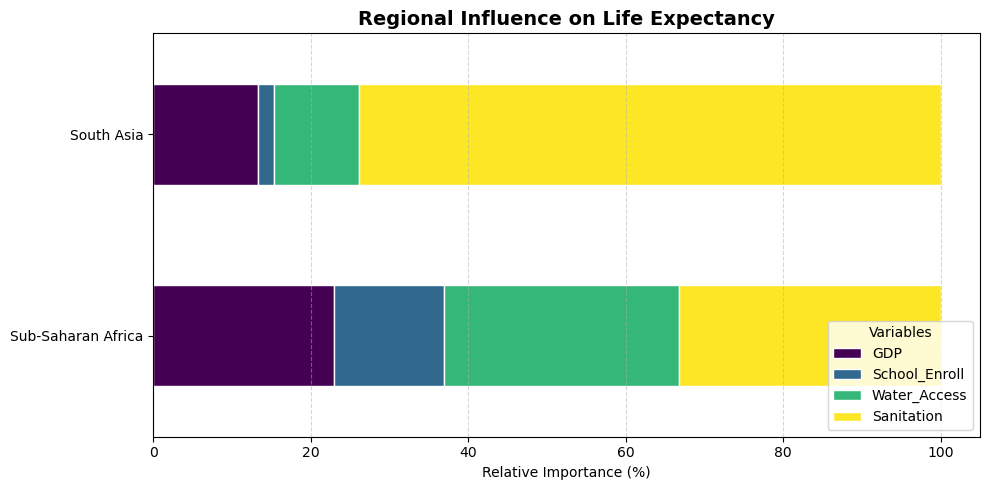

Graph saved: figures/Sub-Saharan_Africa_Country_Comparison_(Highest_to_Lowest_GDP).png


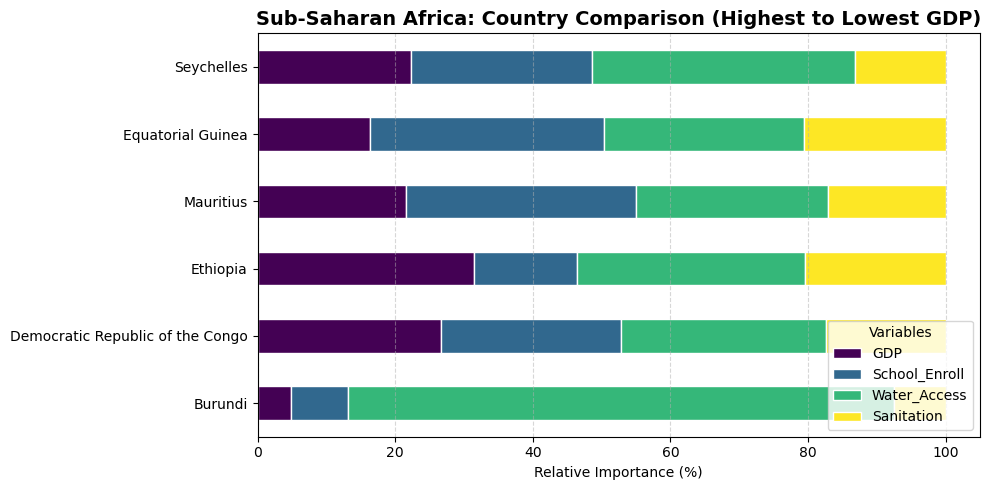

Graph saved: figures/South_Asia_Country_Comparison_(Highest_to_Lowest_GDP).png


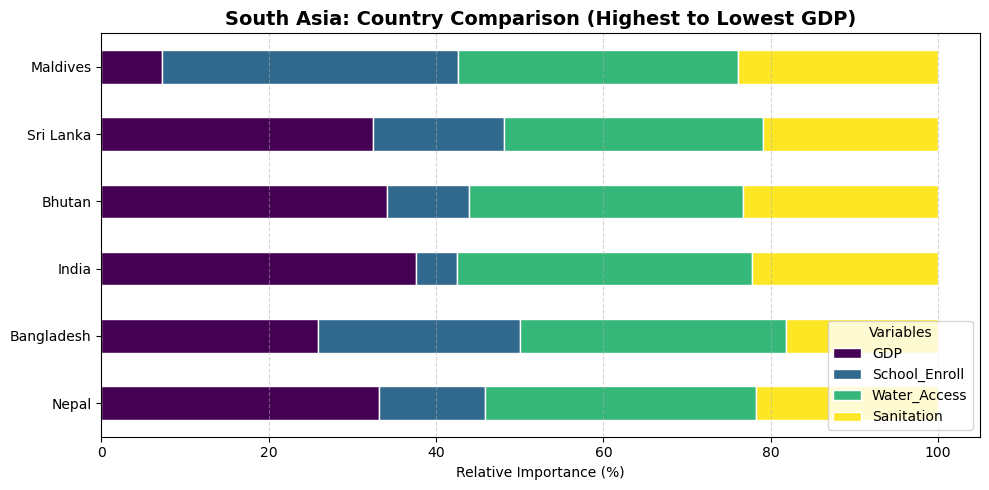

In [19]:
def plot_comparisons(tables_dict):
    plot_data = [
        (tables_dict['Regions'], "Regional Influence on Life Expectancy"),
        (tables_dict['Sub-Saharan Africa'], "Sub-Saharan Africa: Country Comparison (Highest to Lowest GDP)"),
        (tables_dict['South Asia'], "South Asia: Country Comparison (Highest to Lowest GDP)")
    ]
    
    for data_list, title in plot_data:
        if not data_list: continue
        
        fig, ax = plt.subplots(figsize=(10, 5))
        
        df = pd.DataFrame(data_list).rename(columns=col_rename)
        df.plot(kind='barh', stacked=True, ax=ax, cmap='viridis', edgecolor='white')
        
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Relative Importance (%)')
        ax.legend(loc='lower right', title='Variables')
        ax.grid(axis='x', linestyle='--', alpha=0.5)

        plt.tight_layout()

        filename = title.replace(":", "").replace(" ", "_") + ".png"
        
        plt.savefig(f"figures/{filename}")
        print(f"Graph saved: figures/{filename}")
        plt.show()

plot_comparisons(tables)